In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor'] = 'w'
from matplotlib import rc
rc('text',usetex=True)
rc('font',**{'family':'serif','serif':['Computer Modern'], 'size' : 18})
plt.rcParams.update({'font.size': 18})
plt.rcParams['axes.titlesize'] = 18

# Beirut explosion

Data from [Rigby et al. *Preliminary yield estimation of the 2020 Beirut explosion using video footage from social media.* Shock Waves 30, 671–675 (2020).](https://link.springer.com/article/10.1007%2Fs00193-020-00970-z)

In [13]:
tnt2j = 4.294  # 4.294 MJ/kg
kg2j = tnt2j*1e6
kt2j = kg2j*1e6
ton2j = kg2j*1e3

P0 = 0.1e6  # atmospheric pressure
rho0 = 1.23  # air density
a0 = np.sqrt(1.4 * P0 / rho0)  # speed of sound

# Beirut explosion
data_source = ['Diaz', 'Rigby et al.']
df_beirut = pd.DataFrame()
dfs = []
for name in data_source:
    df_tmp = pd.read_excel('data/Beirut.xlsx', sheet_name=name, usecols='A:D')
    e0 = df_tmp['Yield (kt)'][0]*kt2j
    df_tmp['Source']   = [name]*len(df_tmp)
    df_tmp['Test']     = ['Beirut']*len(df_tmp)
    df_tmp['Yield']    = [df_tmp['Yield (kt)'][0]]*len(df_tmp)
    del df_tmp['Yield (kt)']
#     R0 = (e0 / P0)**(1/3)
#     df_tmp['x_scaled'] = df_tmp['t (s)'].apply(lambda x: np.log10(x*a0/R0))
#     df_tmp['y_scaled'] = df_tmp['R (m)'].apply(lambda x: np.log10(x/R0))
    df_beirut = pd.concat([df_beirut, df_tmp], axis=0, ignore_index=True)
    dfs.append(df_tmp)

In [9]:
dfs[1]

,R (m),t (s),Feature,Source,Test,Yield
0,563,1.167,Audio,Rigby et al.,Beirut,0.5
1,566,1.068,Audio,Rigby et al.,Beirut,0.5
2,572,1.068,Audio,Rigby et al.,Beirut,0.5
3,630,1.277,Audio,Rigby et al.,Beirut,0.5
4,675,1.667,Audio,Rigby et al.,Beirut,0.5
5,690,1.568,Audio,Rigby et al.,Beirut,0.5
6,1000,2.269,Audio,Rigby et al.,Beirut,0.5
7,1074,2.338,Audio,Rigby et al.,Beirut,0.5
8,1120,2.500,Audio,Rigby et al.,Beirut,0.5
9,1141,2.600,Audio,Rigby et al.,Beirut,0.5


In [16]:
# R vs t from Dewey Eq (1)
def R_T(t):
    A, B, C = -13.5289, 53.1742, -58.3335
    return A + a0*t + B * np.log(1 + a0*t) + C * np.sqrt(np.log(1 + a0*t))

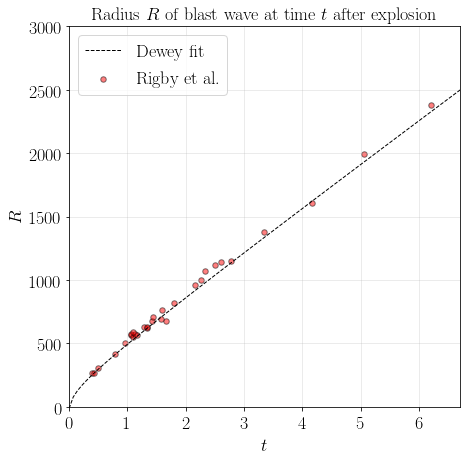

In [36]:
fig, ax = plt.subplots()
fig.set_size_inches(7, 7)
xmin, xmax = 0, 6.7
ymin, ymax = 0, 3000

t_axis = np.linspace(0, 7, 100)

ax.scatter(dfs[1]['t (s)'], dfs[1]['R (m)'], s=30, marker='o', color='r', edgecolor='k', alpha=.5, label='Rigby et al.')
ax.plot(t_axis, R_T(t_axis), 'k--', linewidth=1, label='Dewey fit')
ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], 
#        xscale='log', yscale='log',
       xlabel=r'$t$', ylabel=r'$R$',
       title=r'Radius $R$ of blast wave at time $t$ after explosion')
ax.grid(zorder=-1, alpha=.5, linewidth=0.5)
ax.legend(loc='upper left');

In [27]:
R_T(0.10)

98.98586633335364

In [2]:
df = pd.read_csv('data/GITaylor_Trinity_data.csv')

In [23]:
df['t_sec'] = df['t_msec'] * 1e-3  # convert msec to sec

df['log10_t'] = df['t_sec'].apply(lambda x: np.log10(x))
df['5/2*log10_R'] = df['R_m'].apply(lambda x: 5/2*np.log10(x))
df.head()

,t_msec,R_m,t_sec,log10_t,log10_R,5/2*log10_R
0,0.10,11.1,0.00010,-4.000000,2.613307,2.613307
1,0.24,19.9,0.00024,-3.619789,3.247133,3.247133
2,0.38,25.4,0.00038,-3.420216,3.512084,3.512084
3,0.52,28.8,0.00052,-3.283997,3.648481,3.648481
4,0.66,31.9,0.00066,-3.180456,3.759477,3.759477


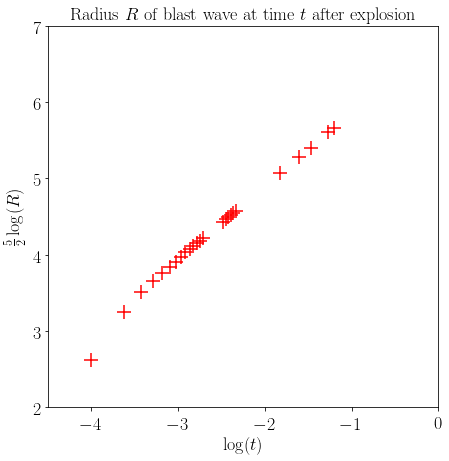

In [14]:
fig, ax = plt.subplots()
fig.set_size_inches(7, 7)
xmin, xmax = -4.5, 0
ymin, ymax = 2, 7
ax.scatter(df['log10_t'], df['5/2*log10_R'], s=180, marker='+', color='r')
ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], 
       xlabel=r'$\log(t)$', ylabel=r'$\frac{5}{2}\log(R)$',
       title=r'Radius $R$ of blast wave at time $t$ after explosion');

Let us fit a straight line to this data using a simple linear regression

In [15]:
# set up data
X = df['log10_t'].values.reshape(1, -1).T
y = df['5/2*log10_R'].values
y.shape, X.shape

((25,), (25, 1))

In [17]:
# fit Linear Regression: y = mx+n
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X, y)
print(f'slope    : m = {model.coef_[0]:.2f}')
print(f'intercept: n = {model.intercept_:.2f}')

slope    : m = 1.01
intercept: n = 6.94


c:\users\jsdiaz\anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


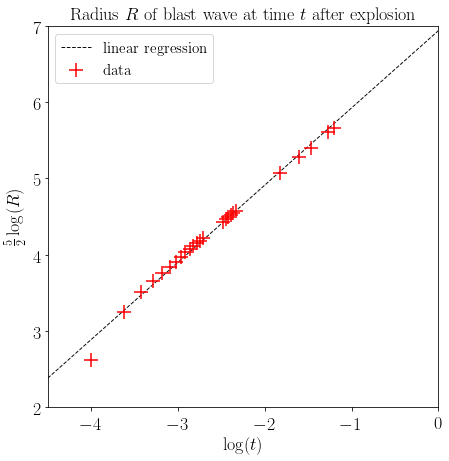

In [18]:
fig, ax = plt.subplots()
fig.set_size_inches(7, 7)
xmin, xmax = -4.5, 0
ymin, ymax = 2, 7

ax.scatter(df['log10_t'], df['5/2*log10_R'], s=180, marker='+', color='r', label='data', zorder=10)
# plot linear fit
logt = np.linspace(xmin, xmax, 2)
ax.plot(logt, model.intercept_ + model.coef_[0] * logt, 'k--', linewidth=1, 
        label=f'linear regression', zorder=0, alpha=0.95)

ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], 
       xlabel=r'$\log(t)$', ylabel=r'$\frac{5}{2}\log(R)$',
       title=r'Radius $R$ of blast wave at time $t$ after explosion');
ax.legend(fontsize=15);
# fig.savefig('plots/TrinityBlastWave-Taylor.pdf', bbox_inches='tight')

The energy is given in terms of the intercept $n$ as

$$ E_0 = \frac{10^{2n}\rho_0}{S(\gamma)^5} $$

where $\rho_0$=1.23 kg/m$^3$ in the density of the undisturbed air and the constant for air ($\gamma=1.4$) is $S(1.4)^{-5}$ = 0.856.

In [22]:
# explosion yield in kt TNT
# 1 TJ = 4.25 kt TNT
E0 = 10**(2*model.intercept_) * 0.856 * 1.23
print(f'E = {E0 / ( 4.25e12):.1f} kt TNT  ({E0:.2E} J)')

E = 19.0 kt TNT  (8.05E+13 J)
